Olman Alexander Silva
2343025

Desarrollo guias del proyecto FDAYCN 1, 2 y 3.

3. Training a Neural Networks

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

In [2]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 1.1425, -0.0440],
        [-0.5725,  0.6557]], requires_grad=True)


In [3]:
y = x**2
print(y)

tensor([[1.3054, 0.0019],
        [0.3278, 0.4299]], grad_fn=<PowBackward0>)


In [4]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

In [6]:
## Let's reduce the tensor y to a scalar value, the mean.
z = y.mean()
print(z)

tensor(0.5163, grad_fn=<MeanBackward0>)


In [7]:
#Check the gradients for x and y but they are empty currently
print(x.grad)

None


In [12]:
#Calculate the gradients with .backward method on a variable, z for example
# Re-run the forward pass to create a new graph
x = torch.randn(2,2, requires_grad=True)
y = x**2
z = y.mean()

z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.1705, -0.1543],
        [ 0.3738,  0.0419]])
tensor([[ 0.1705, -0.1543],
        [ 0.3738,  0.0419]], grad_fn=<DivBackward0>)


Get the data and define the network

In [17]:
from torchvision import datasets, transforms

# Define a transform to normalize the data for grayscale images
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)) # Changed to single values for grayscale
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


I'll build a network with nn.Sequential here. Only difference from the last part is I'm not actually using softmax on the output, but instead just using the raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to inaccuracies with representing numbers as floating points, computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the logits, to calculate the loss.

In [14]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

Training the network

In [15]:
#Define loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Below I'll go through one training step and print out the weights and gradients so you can see how it changes

In [18]:
print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[ 0.0107,  0.0324,  0.0312,  ..., -0.0173, -0.0214, -0.0059],
        [ 0.0198, -0.0357,  0.0202,  ...,  0.0113, -0.0328,  0.0246],
        [-0.0351, -0.0047,  0.0165,  ..., -0.0186,  0.0095,  0.0352],
        ...,
        [ 0.0125, -0.0115,  0.0277,  ..., -0.0301,  0.0267, -0.0109],
        [ 0.0279,  0.0070, -0.0268,  ...,  0.0257,  0.0303, -0.0207],
        [ 0.0110, -0.0184,  0.0124,  ...,  0.0279, -0.0025, -0.0217]],
       requires_grad=True)
Gradient - tensor([[-0.0015, -0.0015, -0.0015,  ..., -0.0015, -0.0015, -0.0015],
        [ 0.0041,  0.0041,  0.0041,  ...,  0.0041,  0.0041,  0.0041],
        [ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        ...,
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007]])


In [19]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 0.0107,  0.0324,  0.0312,  ..., -0.0172, -0.0214, -0.0059],
        [ 0.0198, -0.0357,  0.0201,  ...,  0.0113, -0.0328,  0.0246],
        [-0.0351, -0.0047,  0.0165,  ..., -0.0186,  0.0095,  0.0352],
        ...,
        [ 0.0125, -0.0115,  0.0277,  ..., -0.0301,  0.0267, -0.0109],
        [ 0.0279,  0.0070, -0.0268,  ...,  0.0257,  0.0303, -0.0206],
        [ 0.0110, -0.0184,  0.0124,  ...,  0.0279, -0.0025, -0.0217]],
       requires_grad=True)


Training for real

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [21]:
epochs = 3
print_every = 40
steps = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)

        optimizer.zero_grad()

        # Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))

            running_loss = 0

Epoch: 1/3...  Loss: 2.2916
Epoch: 1/3...  Loss: 2.2729
Epoch: 1/3...  Loss: 2.2448
Epoch: 1/3...  Loss: 2.2227
Epoch: 1/3...  Loss: 2.2028
Epoch: 1/3...  Loss: 2.1726
Epoch: 1/3...  Loss: 2.1490
Epoch: 1/3...  Loss: 2.1151
Epoch: 1/3...  Loss: 2.0762
Epoch: 1/3...  Loss: 2.0415
Epoch: 1/3...  Loss: 1.9946
Epoch: 1/3...  Loss: 1.9575
Epoch: 1/3...  Loss: 1.9090
Epoch: 1/3...  Loss: 1.8419
Epoch: 1/3...  Loss: 1.7738
Epoch: 1/3...  Loss: 1.7115
Epoch: 1/3...  Loss: 1.6673
Epoch: 1/3...  Loss: 1.5714
Epoch: 1/3...  Loss: 1.5136
Epoch: 1/3...  Loss: 1.4499
Epoch: 1/3...  Loss: 1.3744
Epoch: 1/3...  Loss: 1.3114
Epoch: 1/3...  Loss: 1.2506
Epoch: 2/3...  Loss: 0.6405
Epoch: 2/3...  Loss: 1.1409
Epoch: 2/3...  Loss: 1.0627
Epoch: 2/3...  Loss: 1.0450
Epoch: 2/3...  Loss: 0.9909
Epoch: 2/3...  Loss: 0.9377
Epoch: 2/3...  Loss: 0.9259
Epoch: 2/3...  Loss: 0.8863
Epoch: 2/3...  Loss: 0.8379
Epoch: 2/3...  Loss: 0.8358
Epoch: 2/3...  Loss: 0.8084
Epoch: 2/3...  Loss: 0.7846
Epoch: 2/3...  Loss:

With the network trained, we can check out it's predictions.

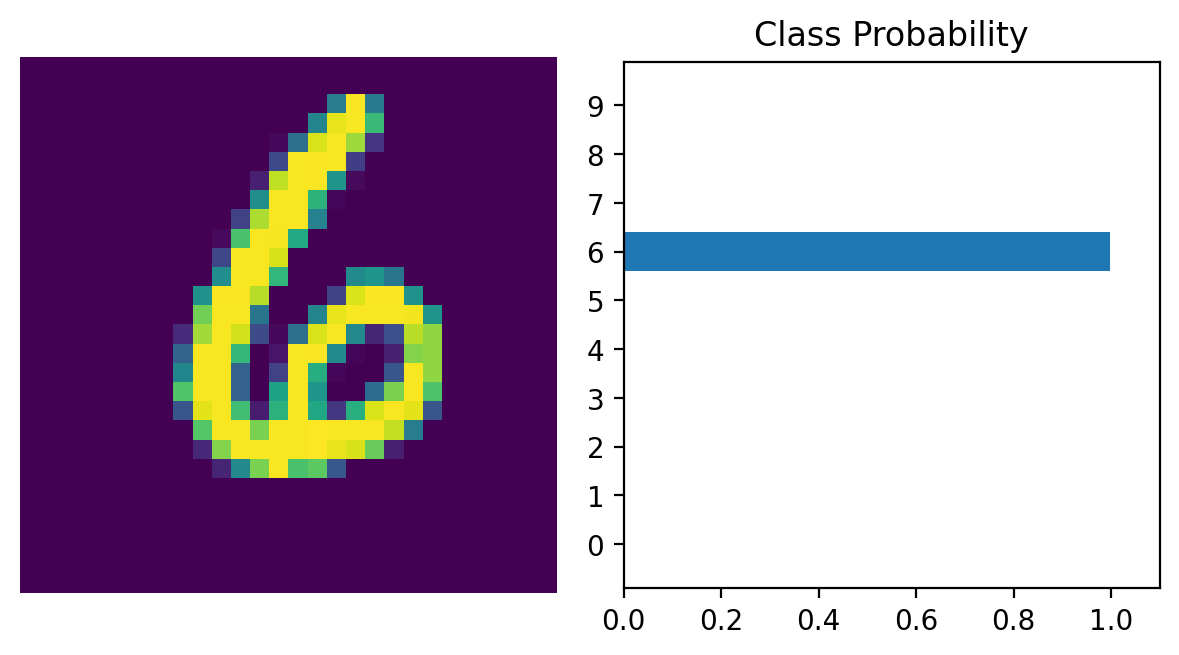

In [29]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
view_classify(img.view(1, 28, 28), ps)

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()